In [2]:
library(igraph)
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(rgl)
library(compiler)

In [3]:
survived <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(V(g)$load, decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived <- cmpfun(survived)

In [4]:
survived_deg <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(degree(g), decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_deg <- cmpfun(survived_deg)

In [5]:
survived_random <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- sample(x = 1:length(g), size = 1)

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_random <- cmpfun(survived_random)

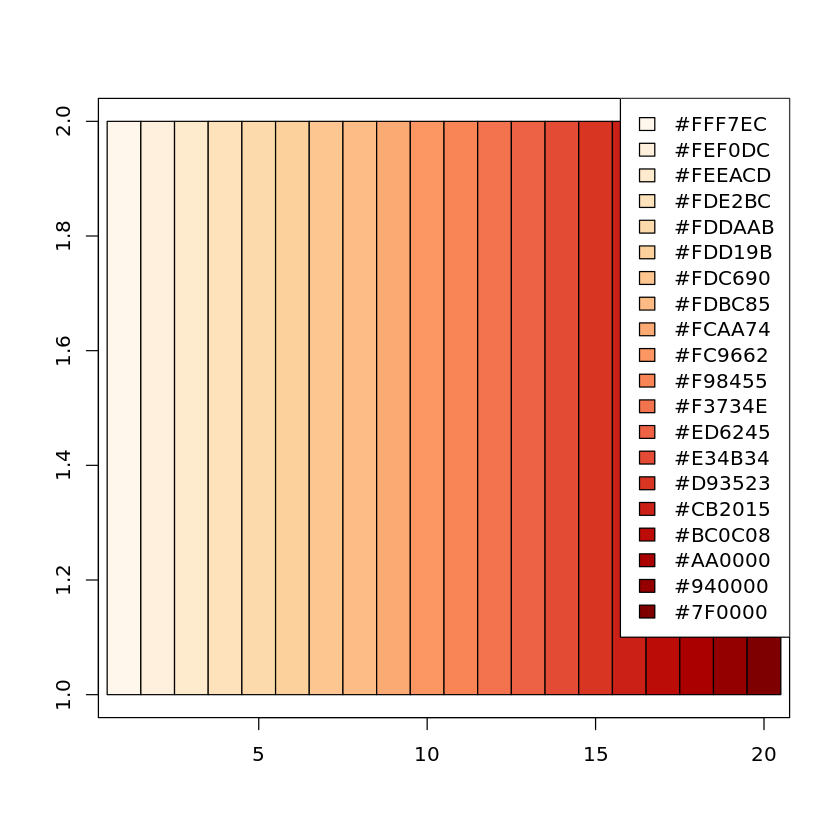

In [6]:
mypal <- rev(colorRampPalette(rev(c(brewer.pal(9, "OrRd"))))(20))
plot(1, 1, type = "n", xlim = c(1, length(mypal)), ylim = c(1, 2), xlab = "", ylab = "")
for (i in 1:length(mypal)) {
  rect(i - 0.5, 1, i + 0.5, 2, col = mypal[i])
}
legend("topright", legend = mypal, fill = mypal, bg = "white")

In [7]:
# mypal

In [202]:
nodes<-read.csv('internet/nodes_clean.csv')
edges<-read.csv('internet/edges.csv')

In [203]:
colnames(nodes)

[1] "X..index" "as_id"    "X_pos"

In [204]:
head(edges)

,X..source,target
,<int>,<int>
1,0,3490
2,1,701
3,1,2914
4,1,2828
5,1,286
6,1,293


In [205]:
layout<-as.matrix(nodes[,c(2,3)],rownames.force = F)
layout <- layout.norm(layout, -1, 1, -1, 1)

In [206]:
head(layout)

as_id,X_pos
-0.35419655,-0.26764828
-0.03564651,-0.20763614
-0.25647477,-0.07705896
0.12450623,-0.26076969
0.32171658,-0.40192561
-0.04838580,-0.35253494


In [207]:
el<-as.matrix(edges+1)
g<-graph_from_edgelist(el = el, directed = FALSE)

In [208]:
btw<-betweenness(g, normalized=FALSE,  directed = F)

In [209]:
index <- which.max(btw)

In [210]:
btw_log <- log(1+btw)

In [211]:
# normalize and convert to integer between 1 and 20
btw_col_idx <- 1 + floor((19)*(btw_log - min(btw_log))/(max(btw_log)-min(btw_log)))

In [212]:
colors<-mypal[btw_col_idx]

In [213]:
# mypal[bet][3782]<-'#0000FF'

In [214]:
ei <- incident(g, index, mode = 'all')
E(g)$color_cst<-'grey'
E(g)[ei]$width_cst<-0.5
E(g)[-ei]$width_cst<-NA
E(g)[ei]$color_cst<-'grey40'
E(g)[-ei]$color_cst<-'grey60'

In [226]:
pdf("internet/whole_graph.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<--0.2
x_right_1<--0.1
y_top_1<--0.15
y_bottom_1<--0.25

x_left_2<-0.1
x_right_2<-0.6
y_top_2<--0.5
y_bottom_2<--1

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
legend(-1, 1, legend=c(paste('Degree of selected node:', degree(g, v =index)),
                       paste('Betweenness of node:', format(btw[index], scientific = TRUE))),
       bg='white', cex=2)

plot(g, layout = layout, vertex.size = 0.5, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,edge.color=E(g)$color_cst, edge.width=E(g)$width_cst,
     axes = T,main='Zoom on node of highest btw',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = 0.1, #vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T, main='Zoom on detail',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()
dev.off()

png 
  2

In [227]:
deg_graph<-degree(g)

In [228]:
fit_res<-fit_power_law(deg_graph, xmin = 1)

In [229]:
fit_res

$continuous
[1] FALSE

$alpha
[1] 1.80072

$xmin
[1] 1

$logLik
[1] -13356.29

$KS.stat
[1] 0.1761675

$KS.p
[1] 0

In [230]:
f <- function(g, x) {
    function(x) {
        x^-g
    }
}

In [231]:
f2<-f(2)
f3<-f(3)
f_c<-f(fit_res$alpha)

In [232]:
deg_dist<-degree_distribution(g)

In [235]:
fitting_df <- data.frame(k = 1:19, p = ifelse(is.finite(log(deg_dist)[2:20]), log(deg_dist)[2:20],
    NA))

In [236]:

linear_model <- lm(p ~ k, data=fitting_df)

In [238]:
pdf("internet/deg_distrib.pdf",width=14, height = 10) 

layout.matrix <- matrix(c(1, 1, 1, 1, 2, 0), nrow = 2, ncol = 3)
lay_plots <- layout(mat = layout.matrix)


x_min <- 1
x_max <- 100
# options(repr.plot.width = 14, repr.plot.height = 7)
par(cex.axis = 1.5, cex.lab = 2, cex.main = 1, oma=c(2,2,2,2))
plot(1:19, deg_dist[2:20], xlab = "Degree k", ylab = "Prob(k)", pch = 16, cex = 2.3,
    xlim = c(1, 30), log = "xy")
curve(f_c, from = x_min, to = x_max, add = T, log = "xy", col = "red", lwd = 3)
curve(f2, from = x_min, to = x_max, add = T, log = "xy", col = "blue", lwd = 3)
curve(f3, from = x_min, to = x_max, add = T, log = "xy", col = "darkgreen", lwd = 3)
grid()
legend("bottomleft", legend = c(paste("Fit pwr law:", round(fit_res$alpha,2)), "gamma=2", "gamma=3"), col = c("red",
    "blue", "darkgreen"), lty = 1, lwd = 3, cex = 2)

plot(1:19, log(deg_dist[2:20]), xlab = "Degree k", ylab = "log(prob(k))", pch = 16,
    cex = 1.3, xlim = c(1, 22))
abline(a = linear_model$coefficients[[1]], b = linear_model$coefficients[[2]])
grid()
legend('topright', legend=c('Linear model'), lwd=2, lty=1, cex=2)
dev.off()

png 
  2

In [239]:
betwe<-betweenness(g, normalized=FALSE)

In [240]:
pdf("internet/betwe_distrib.pdf",width=7, height = 7) 

par(mar = c(5, 4, 4, 4) + 0.3)
h <- hist(log(betwe), breaks = 18, probability = T, xlab = "Log(btw)", ylab = "P(log(btw))",
    main = "Betweenness distribution", col = "orange", )
par(new = TRUE)
h$counts <- cumsum(h$counts)/sum(h$counts)
plot(h, axes = FALSE, xlab = "", ylab = "", main='', density = 90, col=alpha('blue',0.3) )
axis(side = 4, at = pretty(c(0, 1)))
mtext("Cumulative P(log(btw))", side = 4, line = 3)
grid()
dev.off()

png 
  2

# analysis of tear down at different alpha
refer to script

In [28]:
# alphas <- seq(from = 0, to = 5, by = 0.5)

# g_ratio <- vector()
# g_ratio_deg <- vector()
# g_ratio_random <- vector()
# for (i in seq_along(alphas)) {
#     g_ratio[i] <- survived(g, alpha = alphas[i])
#     g_ratio_deg[i] <- survived_deg(g, alpha = alphas[i])
#     g_ratio_random[i] <- survived_random(g, alpha = alphas[i])
# }

# alphas_zoom <- seq(from = 0.1, to = 1.5, by = 0.1)

# g_ratio_zoom <- vector()
# g_ratio_deg_zoom<-vector()
# g_ratio_random_zoom<-vector()
# for (i in seq_along(alphas_zoom)) {
#     g_ratio_zoom[i] <- survived(g, alpha = alphas_zoom[i])
#     g_ratio_deg_zoom[i]<- survived_deg(g, alpha=alphas_zoom[i])
#     g_ratio_random_zoom[i] <- survived_random(g, alpha = alphas_zoom[i])

# }

# plot(alphas, g_ratio)
# plot(alphas, g_ratio_random, add=T, col='red')

# g_ratio_zoom

# plot(alphas_zoom, g_ratio_zoom)
# plot(alphas_zoom, g_ratio_random_zoom, col='red')

In [29]:
g_ratios<-read.csv('internet/plot_g.csv')

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_line()`).”


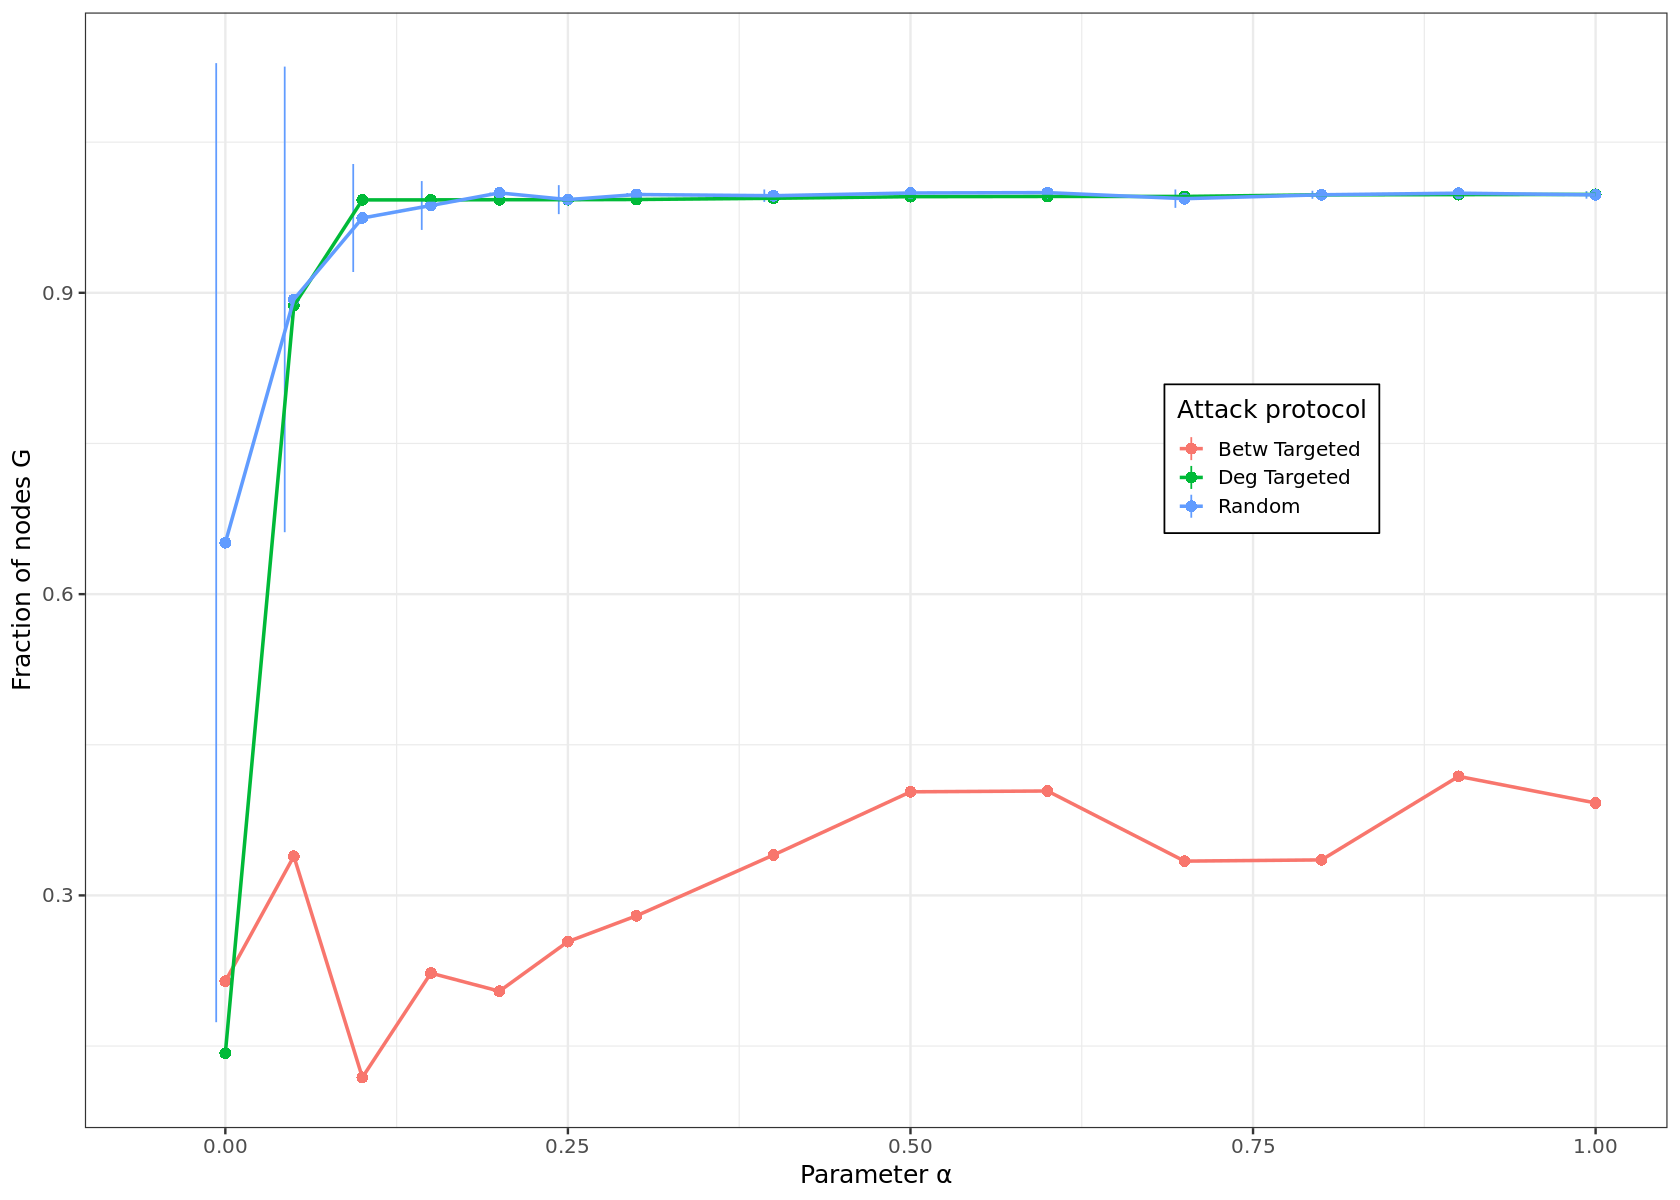

In [30]:
plot_conf <- ggplot(g_ratios) + geom_point(aes(x = alpha, y = g_ratio, col = type),
    shape = 16, size = 3) + geom_linerange(aes(x = alpha, ymax = g_ratio + g_ratio_sd,
    ymin = g_ratio - g_ratio_sd, col = type), position = position_dodge(-0.02)) +
    geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1) + scale_x_continuous(limits = c(-0.05,
    1)) + labs(x = expression(paste("Parameter ", alpha)), y = "Fraction of nodes G",
    col = "Attack protocol") + theme_bw(base_size = 15) + theme(legend.position = c(0.75,
    0.6), legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black"))

plot_conf

In [31]:
ggsave(plot = plot_conf, filename = 'power/plot_g.pdf', width = 7, height = 5)

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_line()`).”


In [32]:
g_ratios %>% filter(type=='Betw Targeted') -> g_ratios_2

Warning message:
“`position_dodge()` requires non-overlapping x intervals”


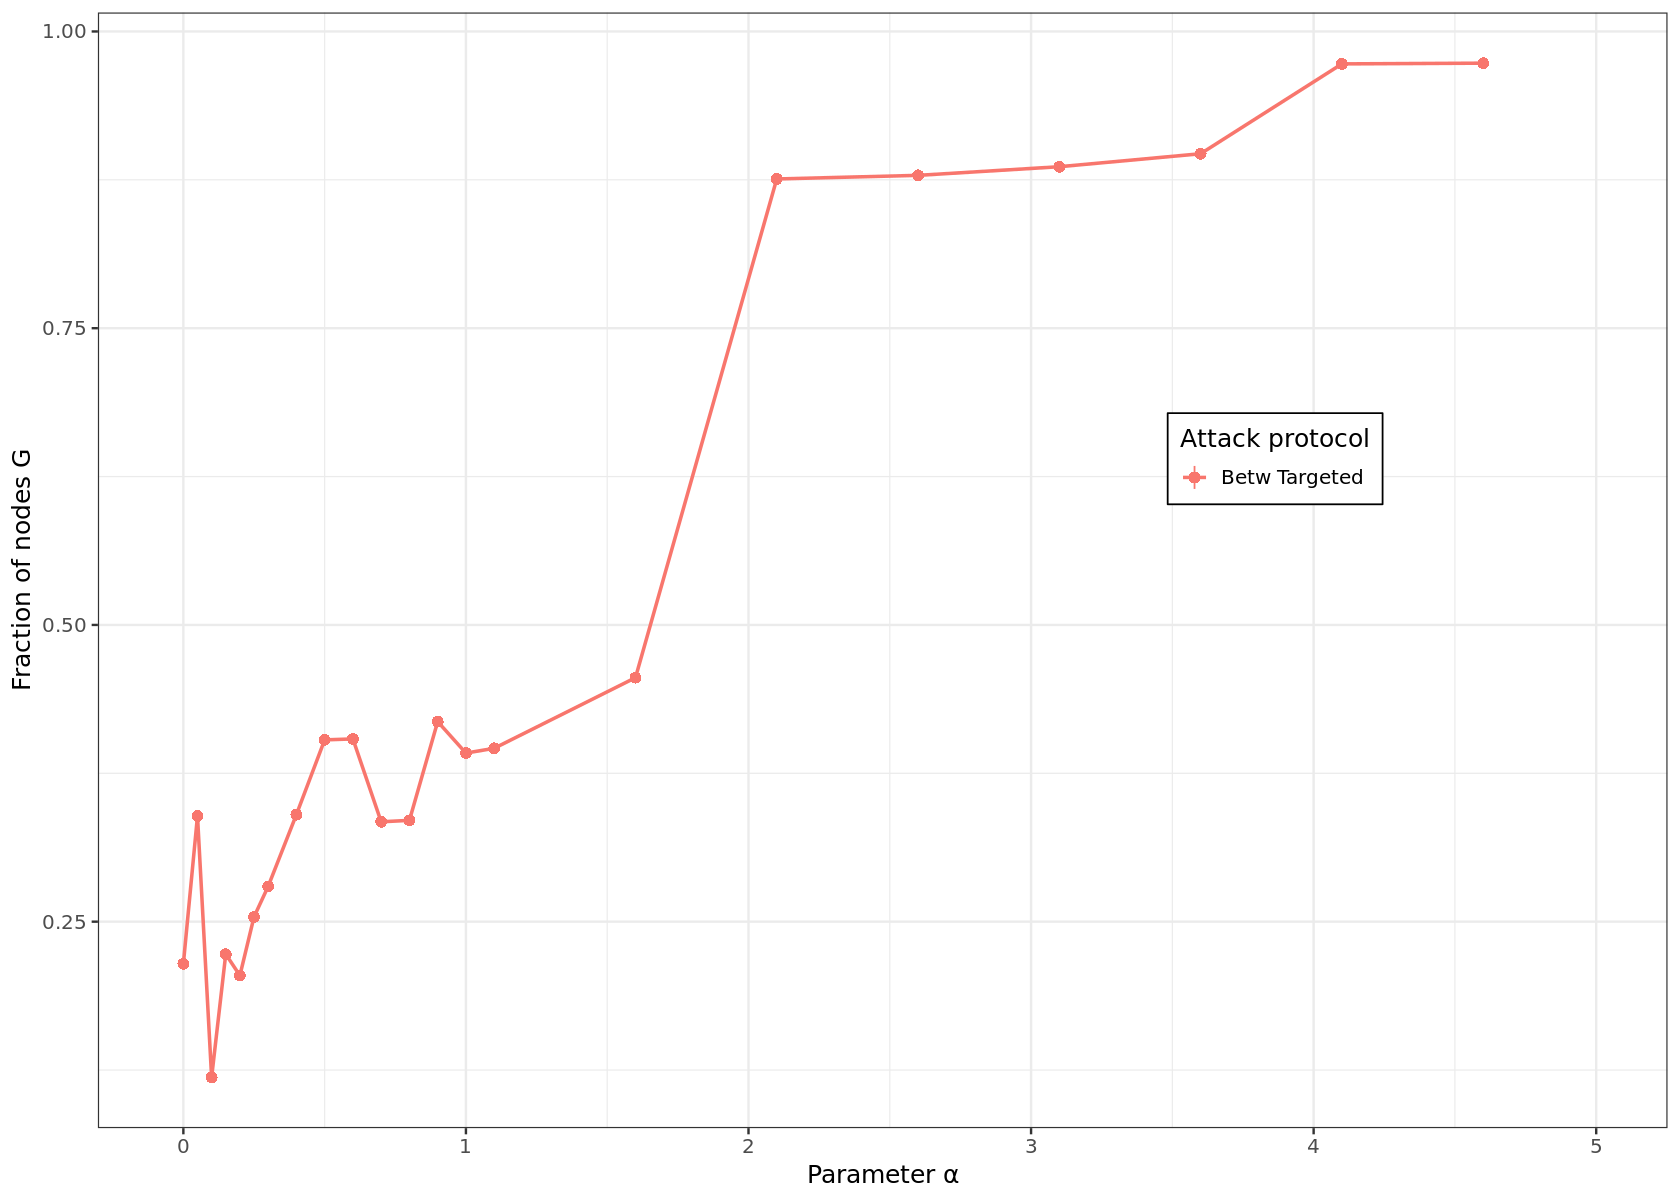

In [33]:
plot_conf_2 <- ggplot(g_ratios_2) + geom_point(aes(x = alpha, y = g_ratio, col = type),
    shape = 16, size = 3) + geom_linerange(aes(x = alpha, ymax = g_ratio + g_ratio_sd,
    ymin = g_ratio - g_ratio_sd, col = type), position = position_dodge(-0.02)) +
    geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1) + scale_x_continuous(limits = c(-0.05,
    5)) + labs(x = expression(paste("Parameter ", alpha)), y = "Fraction of nodes G",
    col = "Attack protocol") + theme_bw(base_size = 15) + theme(legend.position = c(0.75,
    0.6), legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black"))

plot_conf_2

In [34]:
ggsave(plot = plot_conf_2, filename = 'power/plot_g_targeted_only.pdf', width = 7, height = 5)

Warning message:
“`position_dodge()` requires non-overlapping x intervals”


# select alpha and show destruction

In [35]:
alpha<-1

In [36]:
V(g)$cst_ids<-1:length(g)

# V(g)[index]$cst_ids

V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

# overloaded

dead_nodes<-overloaded

g_or <- g

In [37]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [38]:
# hist(log(V(g_or)$load), breaks = 20)

In [39]:
orig_idx<-V(g_or)[overloaded]$cst_ids

In [40]:
orig_idx

[1]   33   47   48  117  130  481  494  505  527  533  534  543  551  554  555
[16]  556  559  563  565  574 2557 2622 3783 3791 3813 3823 3871 3878 3898 3910
[31] 3912 3914 4094 4100 4102 4111 4112 4113 4116 4122 4133 4134 4145 4146 4147
[46] 4150 4157 4173 4174 4188 4189 4195 4202 4203 4212 4219 4222 4228 4318

In [41]:
dead_nodes<-c(dead_nodes, orig_idx)

In [42]:
colors<-mypal[btw_col_idx]

In [43]:
colors[orig_idx]<-'#0000FF'
colors[-orig_idx]<-'#c6c6c6'
colors[index]<-'#FF0000'

In [44]:
pdf("power/whole_graph_failing.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<-0.15
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<-0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes))), bg='white', cex=2)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.size = 0.5, edge.arrow.size = 0, edge.color='black',
     axes = T, main='Zoom on first failed node',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

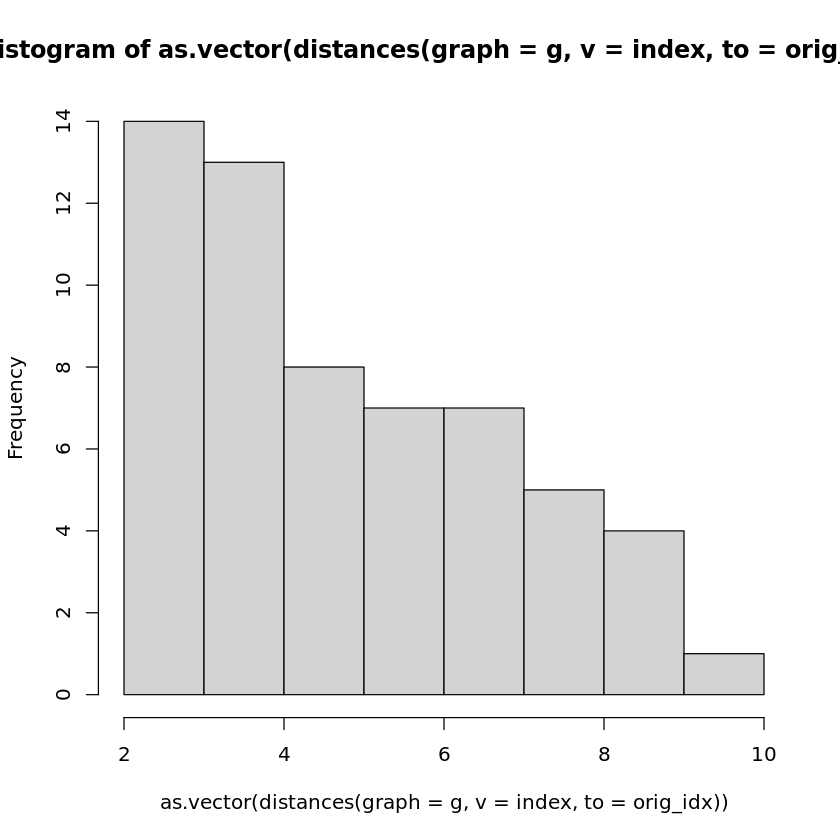

In [45]:
options(repr.plot.width=7, repr.plot.height=7)
h<-hist(as.vector(distances(graph = g, v = index, to = orig_idx)))

In [46]:
pdf("power/distance_first_failed.pdf",width=7, height = 7)
par(cex.lab = 1.5, oma=c(2,2,2,2))
bp<-barplot(h$density, names.arg =min(h$breaks):(max(h$breaks)-1), xlab = "Distance from first failed node",
    ylab = "Frequency [%]", main='', col='orange', ylim=c(0,0.3))
text(bp, h$density + 0.02,paste('#:',h$counts))
grid()
dev.off()

png 
  2

In [47]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [48]:
orig_idx<-V(g_or)[overloaded]$cst_ids

In [49]:
orig_idx

[1]   12   32   41   56   58   60   61   72   74   78   82   83   87   92   99
 [16]  107  121  126  132  137  140  141  142  148  151  157  174  182  186  191
 [31]  192  201  223  226  385  394  428  448  483  484  485  486  496  497  498
 [46]  499  500  522  523  536  537  539  550  560  693  727  838  839  840  841
 [61]  845  846  853  854  866  874  875  883  884  885  886  893  894  901  931
 [76]  932 1126 1477 2224 2236 2263 2299 2343 2344 2345 2352 2365 2563 3762 3768
 [91] 3770 3788 3802 3826 3852 3856 3872 3884 3911 3916 3950 3999 4027 4036 4051
[106] 4087 4091 4161 4218 4447 4449 4459 4462

In [50]:
dead_nodes<-c(dead_nodes, orig_idx)

In [51]:
colors[dead_nodes]<-'#0000FF'
colors[-dead_nodes]<-'#c6c6c6'
colors[index]<-'#FF0000'

In [52]:
pdf("power/whole_graph_failing_2.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<--0.2
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<--0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes))), bg='white', cex=2)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.size = 0.5, edge.arrow.size = 0, edge.color='black',
     axes = T, main='Zoom on first failed node',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

In [53]:
V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

dead_nodes<-overloaded
g_or <- g

counts<-0
while (length(overloaded) > 0) {
    g_or <- delete_vertices(g_or, overloaded)
    V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
    overloaded <- as.vector(V(g_or)[load > capacity])
    orig_idx<-V(g_or)[overloaded]$cst_ids
    dead_nodes<-c(dead_nodes, orig_idx)
    counts<-counts+1
}


n_prime <- max(components(g_or)$csize)
n_orig <- max(components(g)$csize)

# return(n_prime/n_orig)

In [54]:
biggest_cluster_id <- which.max(components(g_or)$csize)

# ids
vert_ids <- V(g_or)[components(g_or)$membership == biggest_cluster_id]

llc_id<-V(g_or)[vert_ids]$cst_ids

In [55]:
colors[dead_nodes]<-'#0000FF'
colors[-dead_nodes]<-'#c6c6c6'
colors[index]<-'#FF0000'
colors[llc_id]<-'#ffca00'

In [56]:
pdf("power/whole_graph_failing_all.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=1.5, cex.lab = 1.5, cex.main=2)
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<--0.2
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<--0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout, vertex.size = 2, vertex.frame.color =alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
     xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes)),
                            paste('Fraction in LCC:', round(n_prime/n_orig,2)*100, '%')), bg='white', cex=2)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.size = 0.5, edge.arrow.size = 0, edge.color='black',
     axes = T, main='Zoom on first failed node',
          xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

# Refer to script

In [57]:
conf<-read.csv('power/null_config.csv')

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”


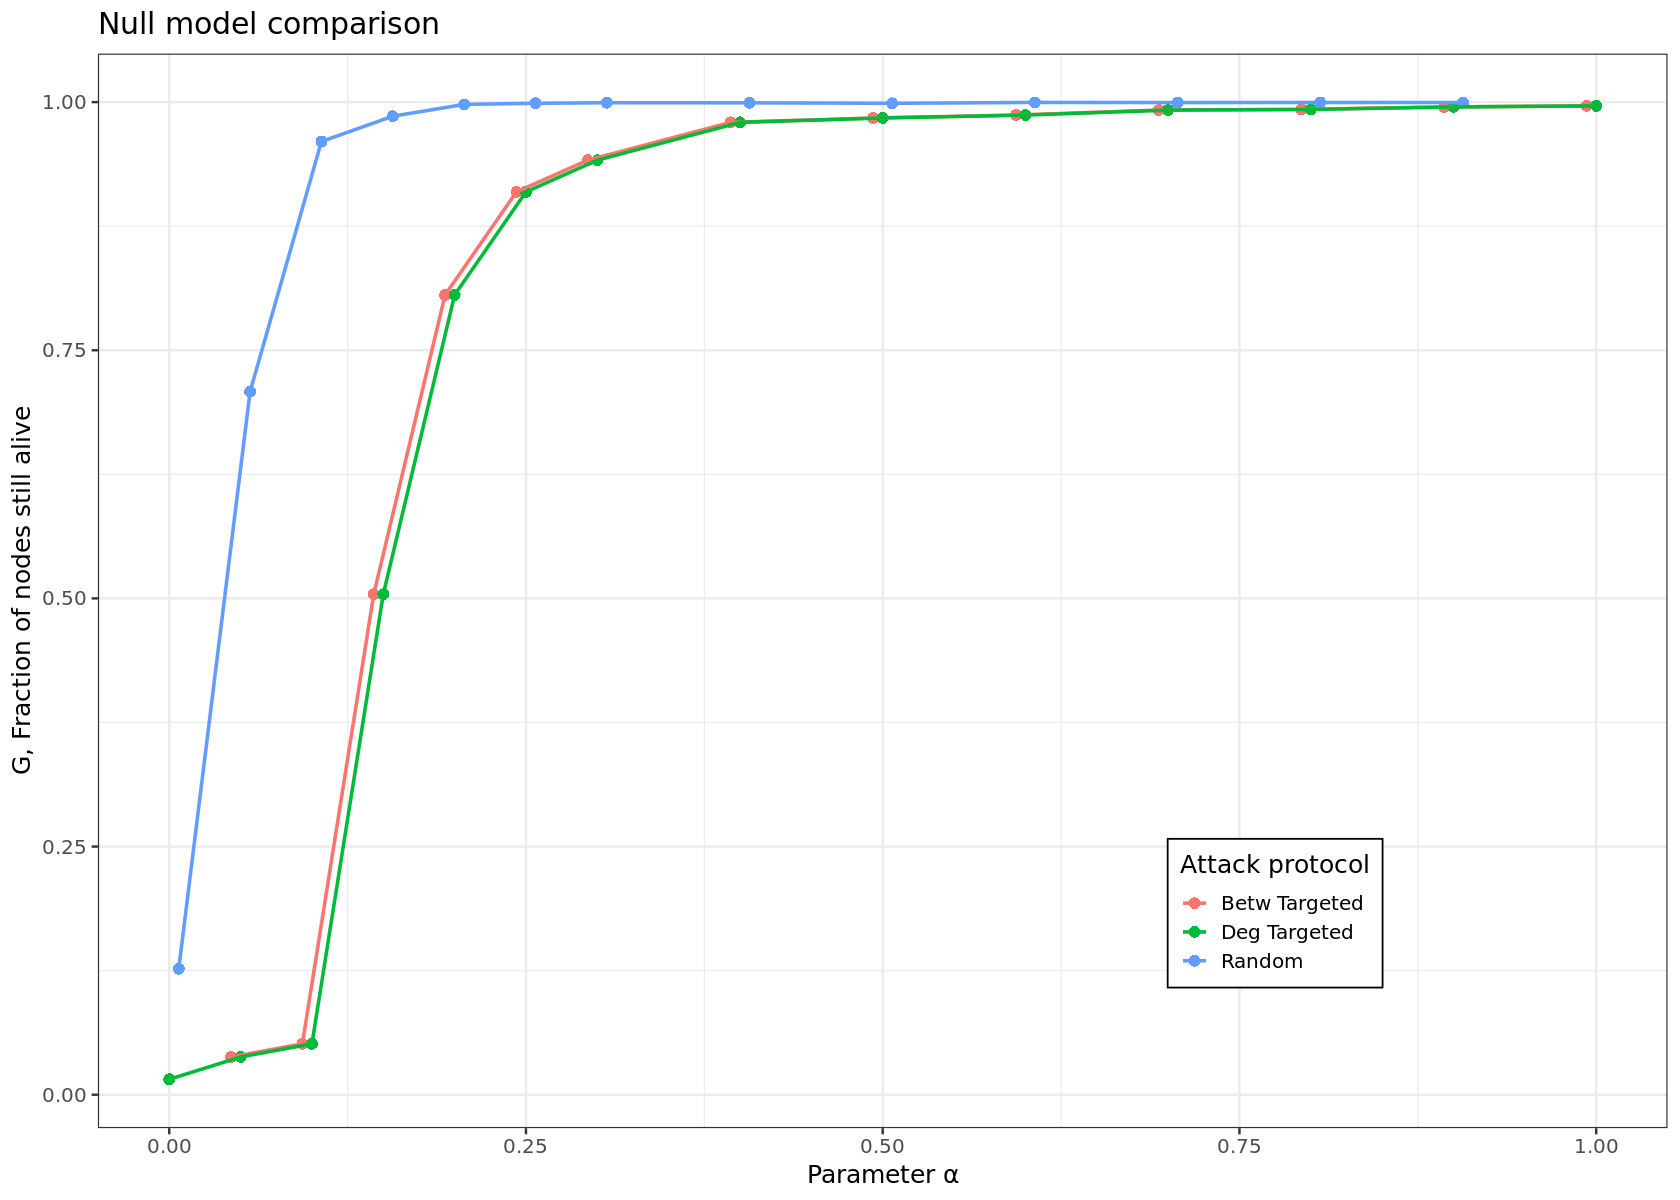

In [58]:
plot_conf <- ggplot(conf) + geom_point(aes(x = alpha, y = g_ratio, col = type), position = position_dodge(0.02),
    shape = 16, size = 3) + geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1, position = position_dodge(0.02)) +
    scale_x_continuous(limits = c(0, 1)) + labs(x = expression(paste("Parameter ",
    alpha)), y = "G, Fraction of nodes still alive", title = "Null model comparison",
    col = "Attack protocol") + theme_bw(base_size = 15) + theme(legend.position = c(0.75,
    0.2), legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black"))

plot_conf

In [59]:
ggsave(plot = plot_conf, filename = 'power/plot_conf.pdf', width = 7, height = 5)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”
